In [1]:
import jax, load_data, rotplot
import math
import jax.numpy as jnp
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import transforms3d
import optimization

In [2]:
[camera,imu,Vicd] = load_data.load(fname="../../trainset",dataset="2")

Data import took: 0.007693052291870117 sec.



In [3]:
#print(Vicd.keys())
#print(Vicd['rots'].shape)
rots = []
#print(Vicd['rots'][:,:,0])
#print(list(transforms3d.euler.mat2euler(Vicd['rots'][:,:,0])))
for i in range(Vicd['rots'].shape[2]):
    rots.append(list(transforms3d.euler.mat2euler(Vicd['rots'][:,:,i])))

rots = jnp.array(rots)
#print(rots.shape)

In [4]:
#print(imu.keys())
sc_ft_ang=3300/1023*(math.pi)/180/3.33
sc_ft_acc=3300/1023/300

Wz = imu['vals'][3]
Wx = imu['vals'][4]
Wy = imu['vals'][5]
Ang_Veloc = np.array([Wx*sc_ft_ang,Wy*sc_ft_ang,Wz*sc_ft_ang])
#print("Angular Velocity shape:", Ang_Veloc.shape)
#print(Ang_Veloc[:,0])

Ax = imu['vals'][0].astype(np.float32)*sc_ft_acc
Ay = imu['vals'][1].astype(np.float32)*sc_ft_acc
Az = imu['vals'][2].astype(np.float32)*sc_ft_acc
Ang_Acc = np.array([-Ax,-Ay,Az],dtype=np.float32)

#print("Angular Acceleration Shape:",Ang_Acc.shape)
#print(Ang_Acc[:,0])

time = imu['ts'][0]
#print("Time shape", time.shape)
tau = np.zeros((len(time)-1,1))
for i,t in enumerate(time,start=0):
    if i == 0:
        continue
    else:
        tau[i-1] = t - time[i-1]

#print("tau shape:", tau.shape)

In [5]:
bias_ang_x=np.average(Ang_Veloc[0,0:100])
bias_ang_y=np.average(Ang_Veloc[1,0:100])
bias_ang_z=np.average(Ang_Veloc[2,0:100])
bias_acc_x=np.average(Ang_Acc[0,0:100])
bias_acc_y=np.average(Ang_Acc[1,0:100])
bias_acc_z=np.average(Ang_Acc[2,0:100])

In [6]:
Ang_Veloc[0] = Ang_Veloc[0] - bias_ang_x
Ang_Veloc[1] = Ang_Veloc[1] - bias_ang_y
Ang_Veloc[2] = Ang_Veloc[2] - bias_ang_z
Ang_Acc[0] = Ang_Acc[0] - bias_acc_x
Ang_Acc[1] = Ang_Acc[1] - bias_acc_y
Ang_Acc[2] = Ang_Acc[2] - bias_acc_z + 1

In [7]:
import quarternions

quarternions_T = quarternions.predict_next_quarternion(tau,Ang_Veloc)

In [8]:
quarts = jnp.array(quarternions_T)

In [17]:
print(quarts.shape)
print(tau[:,0].shape)
print(Ang_Veloc.T.shape)
print(Ang_Acc.T.shape)

(4698, 4)
(4697,)
(4698, 3)
(4698, 3)


In [11]:
optimized_qts = optimization.optimize(quarts,Ang_Acc.T,tau[:,0],Ang_Veloc.T)

4698
(4698, 3)
(4698, 3)


IndexError: index 3 is out of bounds for axis 0 with size 3

In [15]:
print(quarts.shape[0])
print(quarts[0])

4698
[1. 0. 0. 0.]


In [8]:
euler_angles = list(map(lambda quart: transforms3d.euler.quat2euler(quart),quarternions_T))
roll = list(map(lambda angles: angles[0],euler_angles))
pitch = list(map(lambda angles: angles[1],euler_angles))
yaw = list(map(lambda angles: angles[2],euler_angles))

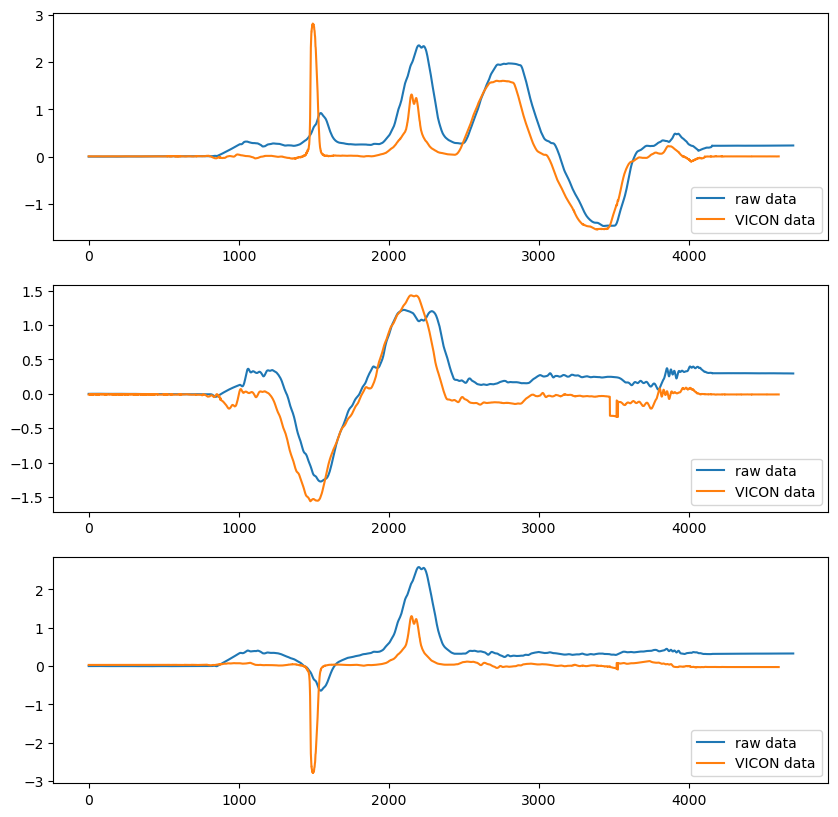

In [9]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(roll)
ax[0].plot(rots[:,0])
ax[1].plot(pitch)
ax[1].plot(rots[:,1])
ax[2].plot(yaw)
ax[2].plot(rots[:,2])
ax[0].legend(['raw data','VICON data'],loc='lower right')
ax[1].legend(['raw data','VICON data'],loc='lower right')
ax[2].legend(['raw data','VICON data'],loc='lower right')

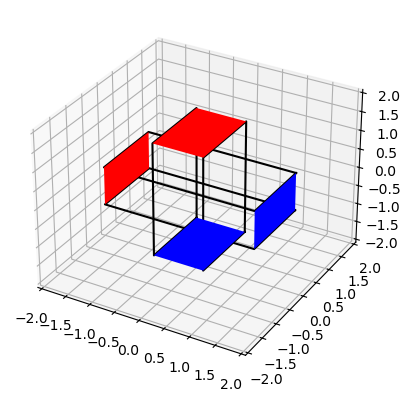

In [10]:
rotplot.example()